In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/user/my-proj/pythorch_test/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

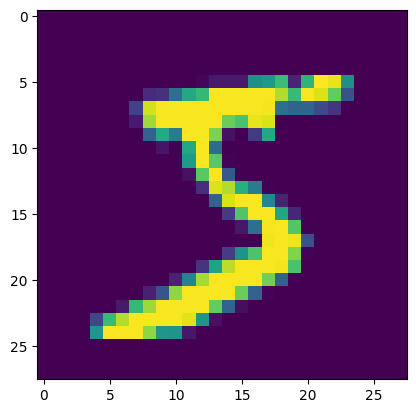

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [38]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=12, kernel_size=3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv3 = torch.nn.Conv2d(
            in_channels=12, out_channels=24, kernel_size=3, padding=0)
        self.conv4 = torch.nn.Conv2d(
            in_channels=24, out_channels=32, kernel_size=3, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 32, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [39]:
lenet5 = lenet5.cuda()

In [51]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=5.0e-5)

In [52]:
batch_size = 100

test_accuracy_history = []
train_accuracy_history = []
test_loss_history = []

X_test = X_test.cuda()
y_test = y_test.cuda()

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    train_accuracy = 0
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].cuda()
        y_batch = y_train[batch_indexes].cuda()
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        train_accuracy += (preds.argmax(dim=1) == y_batch).float().sum().data.cpu()

    train_accuracy_history.append(train_accuracy / len(X_train))
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(accuracy)

tensor(0.9931)
tensor(0.9933)
tensor(0.9934)
tensor(0.9934)
tensor(0.9935)
tensor(0.9934)
tensor(0.9933)
tensor(0.9933)
tensor(0.9932)
tensor(0.9933)


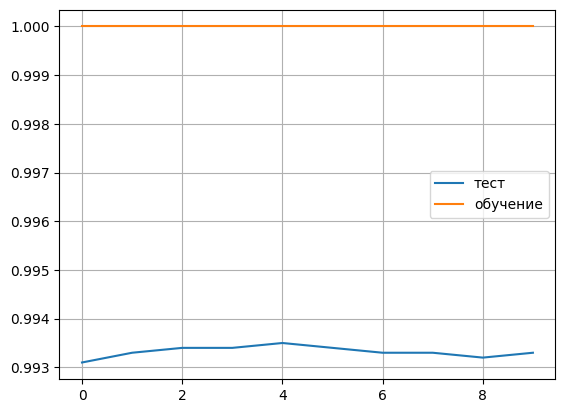

In [54]:
# plt.plot(test_accuracy_history);
plt.plot(test_accuracy_history, label="тест")
plt.plot(train_accuracy_history, label="обучение")
plt.grid()
plt.legend()